In [2]:
import pandas as pd

In [3]:
from PIL import Image

In [4]:
import os

In [5]:
import numpy as np
import tensorflow
from tensorflow import keras
from keras import utils
from tensorflow.keras import Sequential, layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

In [6]:
 from sklearn.metrics import classification_report

In [7]:
def load_image_data():
  data_path = '/content/drive/MyDrive/autism-data/autism/autism.csv'
  base_path = '/content/drive/MyDrive/autism-data/autism/'
  df = pd.read_csv(data_path)

  train_df = df[df['dataset'] == 'train']
  image_list_train = list(train_df['filepaths'])
  imgs = []
  imgs_not_found = []
  for img in image_list_train:
    path = os.path.join(base_path, img)
    if os.path.exists(path):
      image = Image.open(path)
      print(path)
      image = image.resize((256, 256))
      imgs.append(np.array(image))
    else:
      imgs_not_found.append(img)
  for img in imgs_not_found:
    train_df = train_df[train_df['filepaths'] != img]
  X_train = np.array(imgs)
  y_train = train_df['labels'].apply(lambda x: 1 if x == 'autistic' else 0)


  test_df = df[df['dataset'] == 'test']
  image_list_test = list(test_df['filepaths'])
  imgs_test = []
  imgs_test_missing = []
  for img in image_list_test:
    path = os.path.join(base_path, img)
    if os.path.exists(path):
      image = Image.open(path)
      print(path)
      image = image.resize((256, 256))
      imgs_test.append(np.array(image))
    else:
      imgs_test_missing.append(img)
  for img in imgs_test_missing:
    test_df = test_df[train_df['filepaths'] != img]
  X_test = np.array(imgs_test)
  y_test = test_df['labels'].apply(lambda x: 1 if x == 'autistic' else 0)


  val_df = df[df['dataset'] == 'valid']
  image_list_val = list(val_df['filepaths'])
  imgs_val = []
  imgs_val_missing = []
  for img in image_list_val:
    path = os.path.join(base_path, img)
    if os.path.exists(path):
      image = Image.open(path)
      print(path)
      image = image.resize((256, 256))
      imgs_val.append(np.array(image))
    else:
      imgs_val_missing.append(img)
  for img in imgs_val_missing:
    val_df = val_df[train_df['filepaths'] != img]
  X_val = np.array(imgs_val)
  y_val = val_df['labels'].apply(lambda x: 1 if x == 'autistic' else 0)

  return X_train, y_train, X_test, y_test, X_val, y_val


In [8]:
X_train, y_train, X_test, y_test, X_val, y_val = load_image_data()

/content/drive/MyDrive/autism-data/autism/train/autistic/0001.jpg
/content/drive/MyDrive/autism-data/autism/train/autistic/0002.jpg
/content/drive/MyDrive/autism-data/autism/train/autistic/0003.jpg
/content/drive/MyDrive/autism-data/autism/train/autistic/0004.jpg
/content/drive/MyDrive/autism-data/autism/train/autistic/0005.jpg
/content/drive/MyDrive/autism-data/autism/train/autistic/0006.jpg
/content/drive/MyDrive/autism-data/autism/train/autistic/0007.jpg
/content/drive/MyDrive/autism-data/autism/train/autistic/0008.jpg
/content/drive/MyDrive/autism-data/autism/train/autistic/0009.jpg
/content/drive/MyDrive/autism-data/autism/train/autistic/0010.jpg
/content/drive/MyDrive/autism-data/autism/train/autistic/0011.jpg
/content/drive/MyDrive/autism-data/autism/train/autistic/0012.jpg
/content/drive/MyDrive/autism-data/autism/train/autistic/0013.jpg
/content/drive/MyDrive/autism-data/autism/train/autistic/0014.jpg
/content/drive/MyDrive/autism-data/autism/train/autistic/0015.jpg
/content/d

In [9]:
X_train.shape

(2526, 256, 256, 3)

In [10]:
y_train.shape

(2526,)

In [11]:
X_test.shape

(200, 256, 256, 3)

In [12]:
y_test.shape

(200,)

In [13]:
X_val.shape

(200, 256, 256, 3)

In [14]:
y_test.shape

(200,)

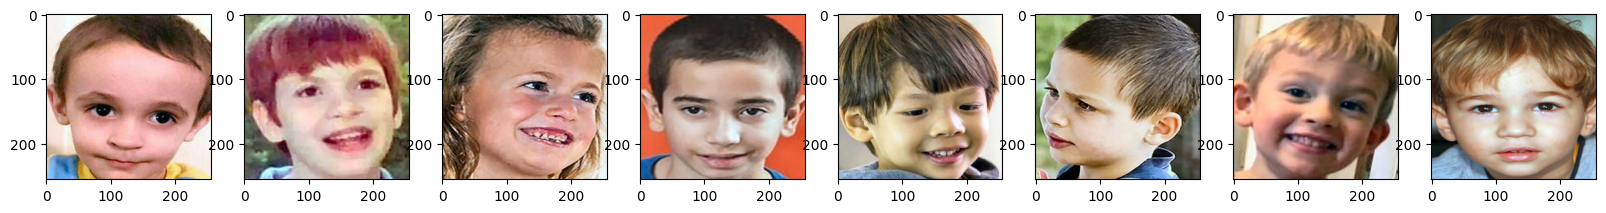

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,15))
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(X_train[i])

In [16]:
def load_own_model():

    model = Sequential()
    model.add(Rescaling(1./255, input_shape=(256,256,3)))

    model.add(layers.Conv2D(16, kernel_size=10, activation='relu'))
    model.add(layers.MaxPooling2D(3))

    model.add(layers.Conv2D(32, kernel_size=8, activation="relu"))
    model.add(layers.MaxPooling2D(3))

    model.add(layers.Conv2D(32, kernel_size=6, activation="relu"))
    model.add(layers.MaxPooling2D(3))

    model.add(layers.Flatten())
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    opt = optimizers.Adam(learning_rate=1e-4)
    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

    return model

In [17]:
model_homemade = load_own_model()
model_homemade.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 247, 247, 16)      4816      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 82, 82, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        32800     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 32)        3

In [18]:
es = EarlyStopping(monitor = 'val_accuracy',
                   mode = 'max',
                   patience = 5,
                   verbose = 1,
                   restore_best_weights = True)


In [19]:
history = model_homemade.fit(X_train, y_train,
                             validation_data = (X_val, y_val),
                             batch_size = 16,
                             epochs = 100,
                             callbacks=[es])

Epoch 1/100
158/158 [==============================] - 17s 27ms/step - loss: 0.6650 - accuracy: 0.6148 - val_loss: 0.6322 - val_accuracy: 0.6200
Epoch 2/100
158/158 [==============================] - 3s 21ms/step - loss: 0.5977 - accuracy: 0.6880 - val_loss: 0.5880 - val_accuracy: 0.6550
Epoch 3/100
158/158 [==============================] - 3s 19ms/step - loss: 0.5606 - accuracy: 0.7114 - val_loss: 0.5678 - val_accuracy: 0.6950
Epoch 4/100
158/158 [==============================] - 3s 19ms/step - loss: 0.5404 - accuracy: 0.7348 - val_loss: 0.5554 - val_accuracy: 0.6900
Epoch 5/100
158/158 [==============================] - 3s 21ms/step - loss: 0.5141 - accuracy: 0.7482 - val_loss: 0.5438 - val_accuracy: 0.7050
Epoch 6/100
158/158 [==============================] - 3s 20ms/step - loss: 0.5064 - accuracy: 0.7482 - val_loss: 0.5401 - val_accuracy: 0.6950
Epoch 7/100
158/158 [==============================] - 3s 19ms/step - loss: 0.4700 - accuracy: 0.7898 - val_loss: 0.5595 - val_accuracy

In [20]:
model_homemade.evaluate(X_test, y_test)

7/7 [==============================] - 1s 14ms/step - loss: 0.3706 - accuracy: 0.8550


[0.3705851435661316, 0.8550000190734863]

In [25]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
model_homemade.save('model_homemade.h5')

In [49]:
def load_model_metric_recall():

    model = Sequential()
    model.add(Rescaling(1./255, input_shape=(256,256,3)))

    model.add(layers.Conv2D(16, kernel_size=10, activation='relu'))
    model.add(layers.MaxPooling2D(3))

    model.add(layers.Conv2D(32, kernel_size=8, activation="relu"))
    model.add(layers.MaxPooling2D(3))

    model.add(layers.Conv2D(32, kernel_size=6, activation="relu"))
    model.add(layers.MaxPooling2D(3))

    model.add(layers.Flatten())
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    opt = optimizers.Adam(learning_rate=1e-4)
    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=[tensorflow.keras.metrics.Recall()])

    return model

In [50]:
model_recall = load_model_metric_recall()
model_recall.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 247, 247, 16)      4816      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 82, 82, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 75, 75, 32)        32800     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 25, 25, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 20, 20, 32)       

In [46]:
es = EarlyStopping(monitor = 'recall',
                   mode = 'max',
                   patience = 5,
                   verbose = 1,
                   restore_best_weights = True)

In [48]:
model_recall.fit(X_train, y_train,
                             validation_data = (X_val, y_val),
                             batch_size = 16,
                             epochs = 100,
                             callbacks=[es])

Epoch 1/100
158/158 [==============================] - ETA: 0s - loss: 0.6652 - recall_5: 0.6184

158/158 [==============================] - 6s 22ms/step - loss: 0.6652 - recall_5: 0.6184 - val_loss: 0.6270 - val_recall_5: 0.8500
Epoch 2/100
157/158 [============================>.] - ETA: 0s - loss: 0.5889 - recall_5: 0.6996

158/158 [==============================] - 3s 19ms/step - loss: 0.5892 - recall_5: 0.6983 - val_loss: 0.6220 - val_recall_5: 0.5000
Epoch 3/100
157/158 [============================>.] - ETA: 0s - loss: 0.5665 - recall_5: 0.7293

158/158 [==============================] - 3s 19ms/step - loss: 0.5659 - recall_5: 0.7292 - val_loss: 0.5897 - val_recall_5: 0.6700
Epoch 4/100
157/158 [============================>.] - ETA: 0s - loss: 0.5488 - recall_5: 0.7448

158/158 [==============================] - 3s 21ms/step - loss: 0.5497 - recall_5: 0.7427 - val_loss: 0.5729 - val_recall_5: 0.6500
Epoch 5/100
157/158 [============================>.] - ETA: 0s - loss: 0.5359 - recall_5: 0.7556

158/158 [==============================] - 3s 20ms/step - loss: 0.5354 - recall_5: 0.7553 - val_loss: 0.5741 - val_recall_5: 0.7800
Epoch 6/100
157/158 [============================>.] - ETA: 0s - loss: 0.5150 - recall_5: 0.7564

158/158 [==============================] - 3s 20ms/step - loss: 0.5151 - recall_5: 0.7561 - val_loss: 0.5585 - val_recall_5: 0.8200
Epoch 7/100
157/158 [============================>.] - ETA: 0s - loss: 0.4987 - recall_5: 0.7919

158/158 [==============================] - 3s 20ms/step - loss: 0.4986 - recall_5: 0.7918 - val_loss: 0.5649 - val_recall_5: 0.6100
Epoch 8/100
156/158 [============================>.] - ETA: 0s - loss: 0.4750 - recall_5: 0.7995

158/158 [==============================] - 3s 21ms/step - loss: 0.4737 - recall_5: 0.8013 - val_loss: 0.5493 - val_recall_5: 0.7800
Epoch 9/100
157/158 [============================>.] - ETA: 0s - loss: 0.4561 - recall_5: 0.8035

158/158 [==============================] - 3s 21ms/step - loss: 0.4559 - recall_5: 0.8036 - val_loss: 0.5372 - val_recall_5: 0.7600
Epoch 10/100
157/158 [============================>.] - ETA: 0s - loss: 0.4306 - recall_5: 0.8320

158/158 [==============================] - 3s 20ms/step - loss: 0.4308 - recall_5: 0.8306 - val_loss: 0.5522 - val_recall_5: 0.8400
Epoch 11/100
156/158 [============================>.] - ETA: 0s - loss: 0.4342 - recall_5: 0.8261

158/158 [==============================] - 3s 20ms/step - loss: 0.4336 - recall_5: 0.8258 - val_loss: 0.5165 - val_recall_5: 0.6500
Epoch 12/100
157/158 [============================>.] - ETA: 0s - loss: 0.4010 - recall_5: 0.8384

158/158 [==============================] - 3s 21ms/step - loss: 0.4015 - recall_5: 0.8393 - val_loss: 0.5196 - val_recall_5: 0.6700
Epoch 13/100
157/158 [============================>.] - ETA: 0s - loss: 0.3826 - recall_5: 0.8432

158/158 [==============================] - 3s 21ms/step - loss: 0.3822 - recall_5: 0.8432 - val_loss: 0.5536 - val_recall_5: 0.7900
Epoch 14/100
 61/158 [==========>...................] - ETA: 1s - loss: 0.3789 - recall_5: 0.8441

KeyboardInterrupt: ignored

In [ ]:
y_pred = model_recall.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred, target_names=target_names))

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

def load_vgg():

    # $CHALLENGIFY_BEGIN

    model = VGG16(weights="imagenet", include_top=False, input_shape=X_train[0].shape)

    # $CHALLENGIFY_END

    return model

In [ ]:
vgg = load_vgg()
vgg.summary()

In [ ]:
def set_nontrainable_layers(model):

    # $CHALLENGIFY_BEGIN
    # Set the first layers to be untrainable
    model.trainable = False

    # $CHALLENGIFY_END

    return model

In [ ]:
vgg_model = set_nontrainable_layers(vgg)
vgg_model.summary()

In [ ]:
from tensorflow.keras import layers, models

def add_last_layers(model):
    '''Take a pre-trained model, set its parameters as non-trainable, and add additional trainable layers on top'''
    # $CHALLENGIFY_BEGIN
    base_model = set_nontrainable_layers(model)
    flatten_layer = layers.Flatten()
    dense_layer = layers.Dense(500, activation='relu')
    prediction_layer = layers.Dense(3, activation='softmax')


    model = models.Sequential([
        base_model,
        flatten_layer,
        dense_layer,
        prediction_layer
    ])
    # $CHALLENGIFY_END
    return model

In [ ]:
vgg_final = add_last_layers(vgg)
vgg_final.summary

In [4]:
# Put Colab in the context of this challenge


# # os.chdir allows you to change directories, like cd in the Terminal
# os.chdir('/content/drive/MyDrive/Colab Notebooks/data-transfer-learning')

In [5]:
#data_path = '/content/drive/My Drive/autism-data/autism/autism.csv'
data_path = '/content/drive/MyDrive/autism-data/autism/autism.csv'

In [6]:
df = pd.read_csv(data_path)

In [7]:
df

,filepaths,labels,dataset
0,test/autistic/001.jpg,autistic,test
1,test/autistic/002.jpg,autistic,test
2,test/autistic/003.jpg,autistic,test
3,test/autistic/004.jpg,autistic,test
4,test/autistic/005.jpg,autistic,test
...,...,...,...
2933,valid/non_autistic/096.jpg,non_autistic,valid
2934,valid/non_autistic/097.jpg,non_autistic,valid
2935,valid/non_autistic/098.jpg,non_autistic,valid
2936,valid/non_autistic/099.jpg,non_autistic,valid


In [8]:
train = df[df['dataset'] == 'train']

In [9]:
train

,filepaths,labels,dataset
200,train/autistic/0001.jpg,autistic,train
201,train/autistic/0002.jpg,autistic,train
202,train/autistic/0003.jpg,autistic,train
203,train/autistic/0004.jpg,autistic,train
204,train/autistic/0005.jpg,autistic,train
...,...,...,...
2733,train/non_autistic/1265.jpg,non_autistic,train
2734,train/non_autistic/1266.jpg,non_autistic,train
2735,train/non_autistic/1267.jpg,non_autistic,train
2736,train/non_autistic/1268.jpg,non_autistic,train


In [10]:
X_train = train['filepaths']

In [11]:
X_train

200         train/autistic/0001.jpg
201         train/autistic/0002.jpg
202         train/autistic/0003.jpg
203         train/autistic/0004.jpg
204         train/autistic/0005.jpg
                   ...             
2733    train/non_autistic/1265.jpg
2734    train/non_autistic/1266.jpg
2735    train/non_autistic/1267.jpg
2736    train/non_autistic/1268.jpg
2737    train/non_autistic/1269.jpg
Name: filepaths, Length: 2538, dtype: object

In [12]:
y_train = train['labels']

In [13]:
y_train

200         autistic
201         autistic
202         autistic
203         autistic
204         autistic
            ...     
2733    non_autistic
2734    non_autistic
2735    non_autistic
2736    non_autistic
2737    non_autistic
Name: labels, Length: 2538, dtype: object

In [14]:
# classes = {'daisy':0, 'dandelion':1, 'rose':2}
# imgs = []
# labels = []
# for (cl, i) in classes.items():
#   print(cl)
#   print(i)


In [15]:
  # images_path = [elt for elt in os.listdir(os.path.join(data_path, cl)) if elt.find('.jpg')>0]
  # for img in tqdm(images_path[:300]):
  #     path = os.path.join(data_path, cl, img)
  #     if os.path.exists(path):
  #         image = Image.open(path)
  #         image = image.resize((256, 256))
  #         imgs.append(np.array(image))
  #         labels.append(i)

In [16]:
base_path = '/content/drive/MyDrive/autism-data/autism/'

In [17]:
image_list_train = list(X_train)

In [18]:
image_list_train

['train/autistic/0001.jpg',
 'train/autistic/0002.jpg',
 'train/autistic/0003.jpg',
 'train/autistic/0004.jpg',
 'train/autistic/0005.jpg',
 'train/autistic/0006.jpg',
 'train/autistic/0007.jpg',
 'train/autistic/0008.jpg',
 'train/autistic/0009.jpg',
 'train/autistic/0010.jpg',
 'train/autistic/0011.jpg',
 'train/autistic/0012.jpg',
 'train/autistic/0013.jpg',
 'train/autistic/0014.jpg',
 'train/autistic/0015.jpg',
 'train/autistic/0016.jpg',
 'train/autistic/0017.jpg',
 'train/autistic/0018.jpg',
 'train/autistic/0019.jpg',
 'train/autistic/0020.jpg',
 'train/autistic/0021.jpg',
 'train/autistic/0022.jpg',
 'train/autistic/0023.jpg',
 'train/autistic/0024.jpg',
 'train/autistic/0025.jpg',
 'train/autistic/0026.jpg',
 'train/autistic/0027.jpg',
 'train/autistic/0028.jpg',
 'train/autistic/0029.jpg',
 'train/autistic/0030.jpg',
 'train/autistic/0031.jpg',
 'train/autistic/0032.jpg',
 'train/autistic/0033.jpg',
 'train/autistic/0034.jpg',
 'train/autistic/0035.jpg',
 'train/autistic/003

In [19]:
import numpy as np

In [20]:
imgs = []

In [21]:
# for img in image_list_train:
#   print(img)

In [22]:
imgs_not_found = []

In [23]:
for img in image_list_train:
  path = os.path.join(base_path, img)
  if os.path.exists(path):
    image = Image.open(path)
    print(path)
    image = image.resize((256, 256))
    imgs.append(np.array(image))
  else:
    imgs_not_found.append(img)

/content/drive/MyDrive/autism-data/autism/train/autistic/0001.jpg
/content/drive/MyDrive/autism-data/autism/train/autistic/0002.jpg
/content/drive/MyDrive/autism-data/autism/train/autistic/0003.jpg
/content/drive/MyDrive/autism-data/autism/train/autistic/0004.jpg
/content/drive/MyDrive/autism-data/autism/train/autistic/0005.jpg
/content/drive/MyDrive/autism-data/autism/train/autistic/0006.jpg
/content/drive/MyDrive/autism-data/autism/train/autistic/0007.jpg
/content/drive/MyDrive/autism-data/autism/train/autistic/0008.jpg
/content/drive/MyDrive/autism-data/autism/train/autistic/0009.jpg
/content/drive/MyDrive/autism-data/autism/train/autistic/0010.jpg
/content/drive/MyDrive/autism-data/autism/train/autistic/0011.jpg
/content/drive/MyDrive/autism-data/autism/train/autistic/0012.jpg
/content/drive/MyDrive/autism-data/autism/train/autistic/0013.jpg
/content/drive/MyDrive/autism-data/autism/train/autistic/0014.jpg
/content/drive/MyDrive/autism-data/autism/train/autistic/0015.jpg
/content/d

,filepaths,labels,dataset
200,train/autistic/0001.jpg,autistic,train
201,train/autistic/0002.jpg,autistic,train
202,train/autistic/0003.jpg,autistic,train
203,train/autistic/0004.jpg,autistic,train
204,train/autistic/0005.jpg,autistic,train
...,...,...,...
2733,train/non_autistic/1265.jpg,non_autistic,train
2734,train/non_autistic/1266.jpg,non_autistic,train
2735,train/non_autistic/1267.jpg,non_autistic,train
2736,train/non_autistic/1268.jpg,non_autistic,train


In [22]:
# for img in image_list_train:
#   try:
#     image = Image.open(os.path.join(base_path, img))
#     print(os.path.join(base_path, img))
#     image = image.resize((256, 256))
#     imgs.append(np.array(image))
#   except:
#     print("image not found")


In [24]:
imgs

[array([[[245, 244, 242],
         [244, 243, 241],
         [243, 242, 240],
         ...,
         [249, 255, 255],
         [249, 255, 255],
         [249, 255, 255]],
 
        [[245, 244, 242],
         [244, 243, 241],
         [244, 243, 241],
         ...,
         [249, 255, 255],
         [249, 255, 255],
         [249, 255, 255]],
 
        [[245, 244, 242],
         [244, 243, 241],
         [244, 243, 241],
         ...,
         [249, 255, 255],
         [249, 255, 255],
         [249, 255, 255]],
 
        ...,
 
        [[202, 219, 217],
         [178, 208, 223],
         [165, 210, 242],
         ...,
         [246, 242, 157],
         [247, 242, 162],
         [247, 243, 168]],
 
        [[184, 206, 212],
         [170, 203, 225],
         [156, 204, 238],
         ...,
         [247, 243, 154],
         [244, 241, 156],
         [242, 239, 159]],
 
        [[177, 202, 210],
         [167, 204, 227],
         [157, 207, 242],
         ...,
         [248, 244, 159],
  

In [105]:
X = np.array(imgs)

In [26]:
imgs_not_found

['train/autistic/1264.jpg',
 'train/autistic/1265.jpg',
 'train/autistic/1266.jpg',
 'train/autistic/1267.jpg',
 'train/autistic/1268.jpg',
 'train/autistic/1269.jpg',
 'train/non_autistic/1264.jpg',
 'train/non_autistic/1265.jpg',
 'train/non_autistic/1266.jpg',
 'train/non_autistic/1267.jpg',
 'train/non_autistic/1268.jpg',
 'train/non_autistic/1269.jpg']

In [30]:
for img in imgs_not_found:
  train = train[train['filepaths'] != img]

In [32]:
train.shape

(2526, 3)

In [33]:
# train_exisiting_images = train[train['filepaths'] != imgs_not_found]

In [34]:
y_train = train['labels']

In [35]:
y_train

200         autistic
201         autistic
202         autistic
203         autistic
204         autistic
            ...     
2727    non_autistic
2728    non_autistic
2729    non_autistic
2730    non_autistic
2731    non_autistic
Name: labels, Length: 2526, dtype: object

In [26]:
X.shape

(2526, 256, 256, 3)

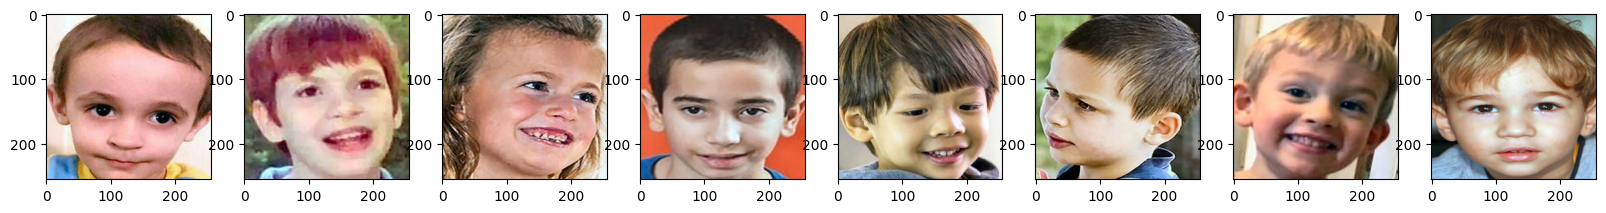

In [36]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,15))
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(X[i])

In [37]:
X[0].shape

(256, 256, 3)

In [38]:
import tensorflow

In [39]:
from tensorflow import keras

In [40]:
from keras import utils

In [41]:
y_df = pd.DataFrame(y_train)

In [42]:
y_df

,labels
200,autistic
201,autistic
202,autistic
203,autistic
204,autistic
...,...
2727,non_autistic
2728,non_autistic
2729,non_autistic
2730,non_autistic


In [43]:
y_df = y_df['labels'].apply(lambda x: 1 if x == 'autistic' else 0)

In [44]:
y_train_encoded = y_df

In [45]:
y_train_encoded

200     1
201     1
202     1
203     1
204     1
       ..
2727    0
2728    0
2729    0
2730    0
2731    0
Name: labels, Length: 2526, dtype: int64

In [48]:
type(y_df)

pandas.core.series.Series

In [90]:
from tensorflow.keras import Sequential, layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

In [91]:
def load_own_model():

    model = Sequential()
    model.add(Rescaling(1./255, input_shape=(256,256,3)))

    model.add(layers.Conv2D(16, kernel_size=10, activation='relu'))
    model.add(layers.MaxPooling2D(3))

    model.add(layers.Conv2D(32, kernel_size=8, activation="relu"))
    model.add(layers.MaxPooling2D(3))

    model.add(layers.Conv2D(32, kernel_size=6, activation="relu"))
    model.add(layers.MaxPooling2D(3))

    model.add(layers.Flatten())
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    opt = optimizers.Adam(learning_rate=1e-4)
    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

    return model

In [96]:
model_homemade = load_own_model()
model_homemade.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 247, 247, 16)      4816      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 82, 82, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 75, 75, 32)        32800     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 20, 20, 32)       

In [49]:
X.shape

(2526, 256, 256, 3)

In [50]:
y_train_encoded.shape

(2526,)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/100
127/127 [==============================] - 8s 65ms/step - loss: 0.4324 - accuracy: 0.8015 - val_loss: 0.6586 - val_accuracy: 0.6601
Epoch 2/100
127/127 [==============================] - 9s 71ms/step - loss: 0.4246 - accuracy: 0.8114 - val_loss: 0.3567 - val_accuracy: 0.8597
Epoch 3/100
127/127 [==============================] - 10s 77ms/step - loss: 0.3989 - accuracy: 0.8257 - val_loss: 0.4903 - val_accuracy: 0.7648
Epoch 4/100
 59/127 [============>.................] - ETA: 4s - loss: 0.3785 - accuracy: 0.8369

KeyboardInterrupt: ignored

In [51]:
test = df[df['dataset'] == 'test']

In [52]:
df.dataset.value_counts()

train    2538
test      200
valid     200
Name: dataset, dtype: int64

In [53]:
test

,filepaths,labels,dataset
0,test/autistic/001.jpg,autistic,test
1,test/autistic/002.jpg,autistic,test
2,test/autistic/003.jpg,autistic,test
3,test/autistic/004.jpg,autistic,test
4,test/autistic/005.jpg,autistic,test
...,...,...,...
195,test/non_autistic/096.jpg,non_autistic,test
196,test/non_autistic/097.jpg,non_autistic,test
197,test/non_autistic/098.jpg,non_autistic,test
198,test/non_autistic/099.jpg,non_autistic,test


In [54]:
X_test = test['filepaths']

In [55]:
y_test = test['labels']

In [56]:
X_test_images = list(test['filepaths'])

In [57]:
test_images = []

In [58]:
test_images_missing = []

In [59]:
from types import EllipsisType
for img in X_test_images:
  path = os.path.join(base_path, img)
  if os.path.exists(path):
    image = Image.open(path)
    print(path)
    image = image.resize((256, 256))
    test_images.append(np.array(image))
  else:
    test_images_missing.append(img)

/content/drive/MyDrive/autism-data/autism/test/autistic/001.jpg
/content/drive/MyDrive/autism-data/autism/test/autistic/002.jpg
/content/drive/MyDrive/autism-data/autism/test/autistic/003.jpg
/content/drive/MyDrive/autism-data/autism/test/autistic/004.jpg
/content/drive/MyDrive/autism-data/autism/test/autistic/005.jpg
/content/drive/MyDrive/autism-data/autism/test/autistic/006.jpg
/content/drive/MyDrive/autism-data/autism/test/autistic/007.jpg
/content/drive/MyDrive/autism-data/autism/test/autistic/008.jpg
/content/drive/MyDrive/autism-data/autism/test/autistic/009.jpg
/content/drive/MyDrive/autism-data/autism/test/autistic/010.jpg
/content/drive/MyDrive/autism-data/autism/test/autistic/011.jpg
/content/drive/MyDrive/autism-data/autism/test/autistic/012.jpg
/content/drive/MyDrive/autism-data/autism/test/autistic/013.jpg
/content/drive/MyDrive/autism-data/autism/test/autistic/014.jpg
/content/drive/MyDrive/autism-data/autism/test/autistic/015.jpg
/content/drive/MyDrive/autism-data/autis

In [60]:
test_images_missing

[]

In [61]:
for img in test_images_missing:
  test = test[test['filepaths'] != img]

In [70]:
X_test = np.array(test_images)

In [64]:
y_test = pd.DataFrame(test['labels'])

In [65]:
y_test = y_test['labels'].apply(lambda x: 1 if x == 'autistic' else 0 )

In [66]:
y_test

0      1
1      1
2      1
3      1
4      1
      ..
195    0
196    0
197    0
198    0
199    0
Name: labels, Length: 200, dtype: int64

0    200
Name: labels, dtype: int64

In [78]:
val = df[df['dataset'] == 'valid']

In [77]:
df['dataset'].value_counts()

train    2538
test      200
valid     200
Name: dataset, dtype: int64

In [65]:
X_val = val['filepaths']

In [99]:
y_val = val['labels']

In [79]:
X_val_images = list(val['filepaths'])

In [71]:
val_images = []

In [67]:
val_images_missing = []

In [80]:
for img in X_val_images:
  path = os.path.join(base_path, img)
  if os.path.exists(path):
    image = Image.open(path)
    print(path)
    image = image.resize((256, 256))
    val_images.append(np.array(image))
  else:
    val_images_missing.append(img)

/content/drive/MyDrive/autism-data/autism/valid/autistic/001.jpg
/content/drive/MyDrive/autism-data/autism/valid/autistic/002.jpg
/content/drive/MyDrive/autism-data/autism/valid/autistic/003.jpg
/content/drive/MyDrive/autism-data/autism/valid/autistic/004.jpg
/content/drive/MyDrive/autism-data/autism/valid/autistic/005.jpg
/content/drive/MyDrive/autism-data/autism/valid/autistic/006.jpg
/content/drive/MyDrive/autism-data/autism/valid/autistic/007.jpg
/content/drive/MyDrive/autism-data/autism/valid/autistic/008.jpg
/content/drive/MyDrive/autism-data/autism/valid/autistic/009.jpg
/content/drive/MyDrive/autism-data/autism/valid/autistic/010.jpg
/content/drive/MyDrive/autism-data/autism/valid/autistic/011.jpg
/content/drive/MyDrive/autism-data/autism/valid/autistic/012.jpg
/content/drive/MyDrive/autism-data/autism/valid/autistic/013.jpg
/content/drive/MyDrive/autism-data/autism/valid/autistic/014.jpg
/content/drive/MyDrive/autism-data/autism/valid/autistic/015.jpg
/content/drive/MyDrive/au

In [81]:
X_val = np.array(val_images)

In [82]:
X_val.shape

(200, 256, 256, 3)

In [83]:
val_images_missing

[]

In [84]:
for img in val_images_missing:
  val = val[val['filepaths'] != img]

In [86]:
y_val = val['labels'].apply(lambda x: 1 if x == 'autistic' else 0 )

In [87]:
y_val

2738    1
2739    1
2740    1
2741    1
2742    1
       ..
2933    0
2934    0
2935    0
2936    0
2937    0
Name: labels, Length: 200, dtype: int64

In [95]:
es = EarlyStopping(monitor = 'val_accuracy',
                   mode = 'max',
                   patience = 5,
                   verbose = 1,
                   restore_best_weights = True)
tensorflow.config.experimental_run_functions_eagerly(True)
history = model_homemade.fit(X, y_train_encoded,
                             validation_split=0.2,
                             batch_size = 16,
                             epochs = 100,
                             callbacks=[es])

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.
/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/100
127/127 [==============================] - ETA: 0s - loss: 0.6317 - accuracy: 0.6376

UnimplementedError: ignored

In [103]:
type(X_train)

numpy.ndarray

In [99]:
y_train_encoded

200     1
201     1
202     1
203     1
204     1
       ..
2727    0
2728    0
2729    0
2730    0
2731    0
Name: labels, Length: 2526, dtype: int64

In [98]:
es = EarlyStopping(monitor = 'val_accuracy',
                   mode = 'max',
                   patience = 5,
                   verbose = 1,
                   restore_best_weights = True)
history2 = model_homemade.fit(X_train, y_train_encoded,
                             validation_data=(X_test, y_test),
                             batch_size = 16,
                             epochs = 100,
                             callbacks=[es])

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/100
126/127 [============================>.] - ETA: 0s - loss: 0.6383 - accuracy: 0.6354

UnimplementedError: ignored

In [102]:
!pip list |grep tensorflow

tensorflow                    2.12.0
tensorflow-datasets           4.9.2
tensorflow-estimator          2.12.0
tensorflow-gcs-config         2.12.0
tensorflow-hub                0.13.0
tensorflow-io-gcs-filesystem  0.32.0
tensorflow-metadata           1.13.1
tensorflow-probability        0.20.1


In [104]:
train.head()

,filepaths,labels,dataset
200,train/autistic/0001.jpg,autistic,train
201,train/autistic/0002.jpg,autistic,train
202,train/autistic/0003.jpg,autistic,train
203,train/autistic/0004.jpg,autistic,train
204,train/autistic/0005.jpg,autistic,train


In [106]:
def load_image_data():
  base_path = '/content/drive/MyDrive/autism-data/autism/'
  df = pd.read_csv(data_path)

  train_df = df[df['dataset'] == 'train']
  image_list_train = list(train_df['filepaths'])
  imgs = []
  imgs_not_found = []
  for img in image_list_train:
    path = os.path.join(base_path, img)
    if os.path.exists(path):
      image = Image.open(path)
      print(path)
      image = image.resize((256, 256))
      imgs.append(np.array(image))
    else:
      imgs_not_found.append(img)
  for img in imgs_not_found:
    train_df = train_df[train_df['filepaths'] != img]
  X_train = np.array(imgs)
  y_train = train_df['labels'].apply(lambda x: 1 if x == 'autistic' else 0)


  test_df = df[df['dataset'] == 'test']
  image_list_test = list(test_df['filepaths'])
  imgs_test = []
  imgs_test_missing = []
  for img in image_list_test:
    path = os.path.join(base_path, img)
    if os.path.exists(path):
      image = Image.open(path)
      print(path)
      image = image.resize((256, 256))
      imgs_test.append(np.array(image))
    else:
      imgs_test_missing.append(img)
  for img in imgs_test_missing:
    test_df = test_df[train_df['filepaths'] != img]
  X_test = np.array(imgs_test)
  y_test = test_df['labels'].apply(lambda x: 1 if x == 'autistic' else 0)


  val_df = df[df['dataset'] == 'valid']
  image_list_val = list(val_df['filepaths'])
  imgs_val = []
  imgs_val_missing = []
  for img in image_list_val:
    path = os.path.join(base_path, img)
    if os.path.exists(path):
      image = Image.open(path)
      print(path)
      image = image.resize((256, 256))
      imgs_val.append(np.array(image))
    else:
      imgs_val_missing.append(img)
  for img in imgs_val_missing:
    val_df = val_df[train_df['filepaths'] != img]
  X_val = np.array(imgs_val)
  y_val = val_df['labels'].apply(lambda x: 1 if x == 'autistic' else 0)

  return X_train, y_train, X_test, y_test, X_val, y_val



# New Section